# Bike Sharing Demand Challenge with Dask

##### Camille Chauliac - camille.chauliac@student.ie.edu
##### MBD O-2

This project is about rewriting our Bike Sharing demand assignment of the Python course. 

On Kaggle's website (https://www.kaggle.com/marklvl/bike-sharing-dataset/home), two datasets (hourly and daily data from 2011-2012) are provided with information about the Bike Sharing service in Washington D.C.


## 1) Importing libraries and datasets

In [157]:
import dask
import dask.dataframe as dd

from dask_ml.linear_model import LogisticRegression

from dask_ml.preprocessing import DummyEncoder, Categorizer
from dask_ml.linear_model import LinearRegression

from sklearn import linear_model

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score

import pandas as pd
import matplotlib.pyplot as plt

In [111]:
df_day = dd.read_csv('/Users/camillechauliac/Desktop/Python-Final-Project/Bike-Sharing-Dataset/day.csv')
df_hour = dd.read_csv('/Users/camillechauliac/Desktop/Python-Final-Project/Bike-Sharing-Dataset/hour.csv')

In [112]:
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [113]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [68]:
df_hour.info()
df_hour.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [9]:
df_day.info()
df_day.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, instant to cnt
dtypes: object(1), float64(4), int64(11)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

We can see that both datasets are pretty similar, but that the hourly dataset provides an extra variable hour which makes the dataset more complete. Therefore, the choice is made to only continue with the hourly dataset from now on. 

As some of the variables in the df_hour dataset have weird datatypes, we start off with changing the respective datatypes of season, year, month, holiday, weekday, workingday and weathersit. Those will be changed into categorical variables.

In [158]:
df_hour[['season']]= df_hour[['season']].astype('category')
df_hour[['yr']]= df_hour[['yr']].astype('category')
df_hour[['mnth']]= df_hour[['mnth']].astype('category')
df_hour[['hr']]= df_hour[['hr']].astype('category')
df_hour[['holiday']]= df_hour[['holiday']].astype('category')
df_hour[['weekday']]= df_hour[['weekday']].astype('category')
df_hour[['workingday']]= df_hour[['workingday']].astype('category')
df_hour[['weathersit']]= df_hour[['weathersit']].astype('category')

In [159]:
df_hour.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                category
hr                  category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [160]:
df_hour = df_hour.drop(["casual", "registered"], axis=1)

In [161]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [166]:
df_hour.season.unique().compute()

0    1
1    2
2    3
3    4
Name: season, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [167]:
df_hour.weathersit.value_counts().compute()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

### Checking for null values in the dataset

In [14]:
df_day.isna().sum().compute()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [15]:
df_hour.isna().sum().compute()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

We can see that we don't have to deal with any null values for this dataset.

[Text(0.5, 1.0, 'Monthly distribution of bike renting')]

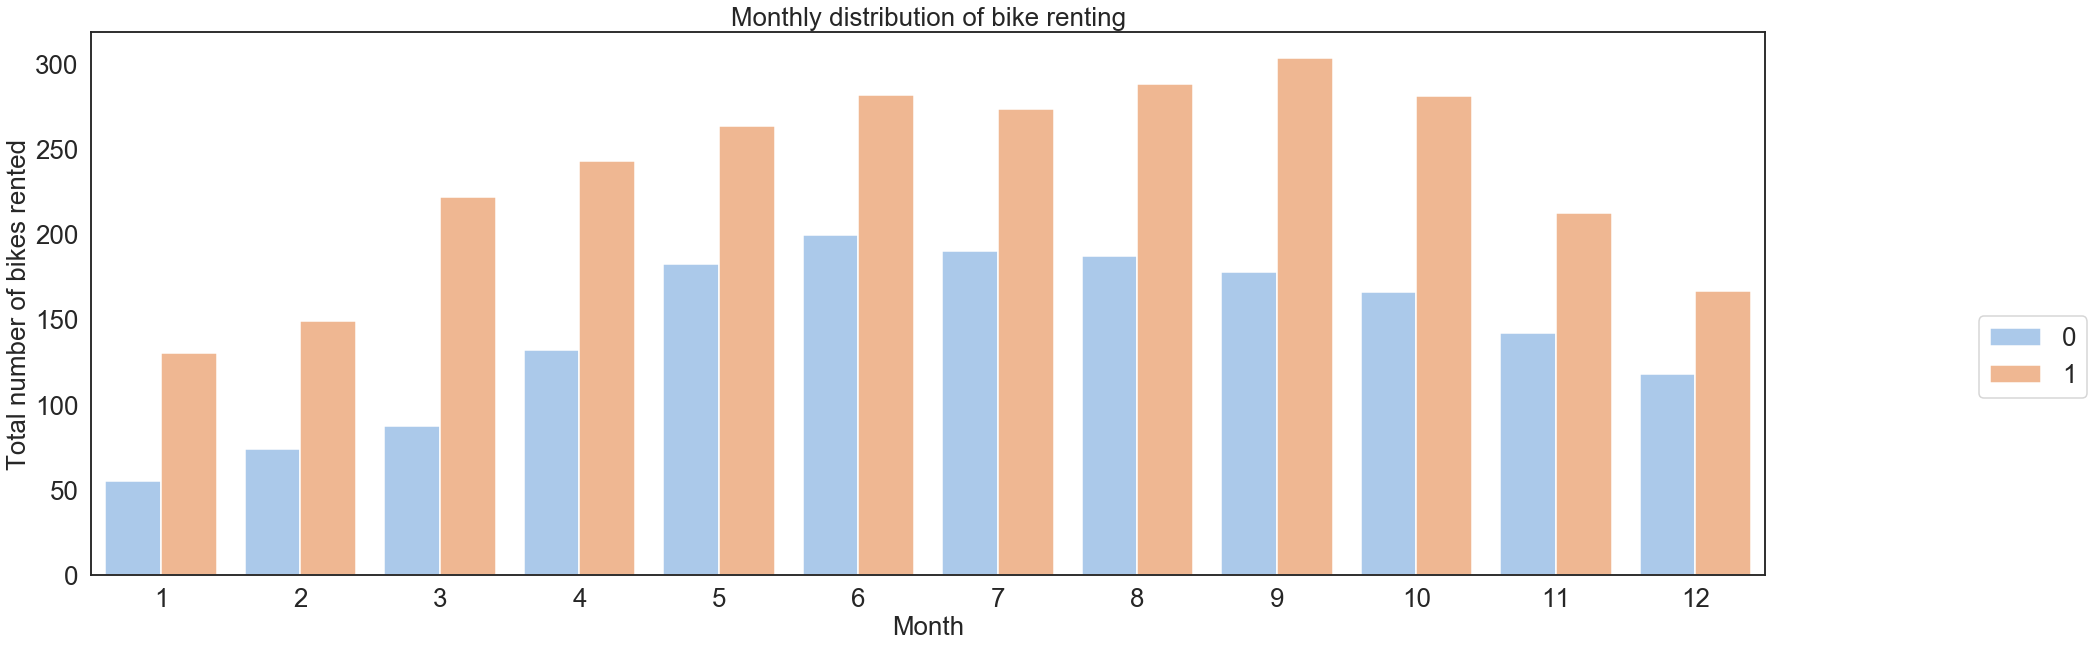

In [154]:
fig, ax = plt.subplots()
sns.barplot(
    "mnth",
    "cnt",
    hue="yr",
    data=df_hour[["mnth", "cnt", "yr"]].compute(),
    palette="pastel",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Month")
plt.ylabel("Total number of rented bikes")
ax.set(title="Monthly distribution of bikes")

In [203]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
params = {'legend.fontsize': 'large',
          'figure.figsize': (25, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}

plt.rcParams.update(params)

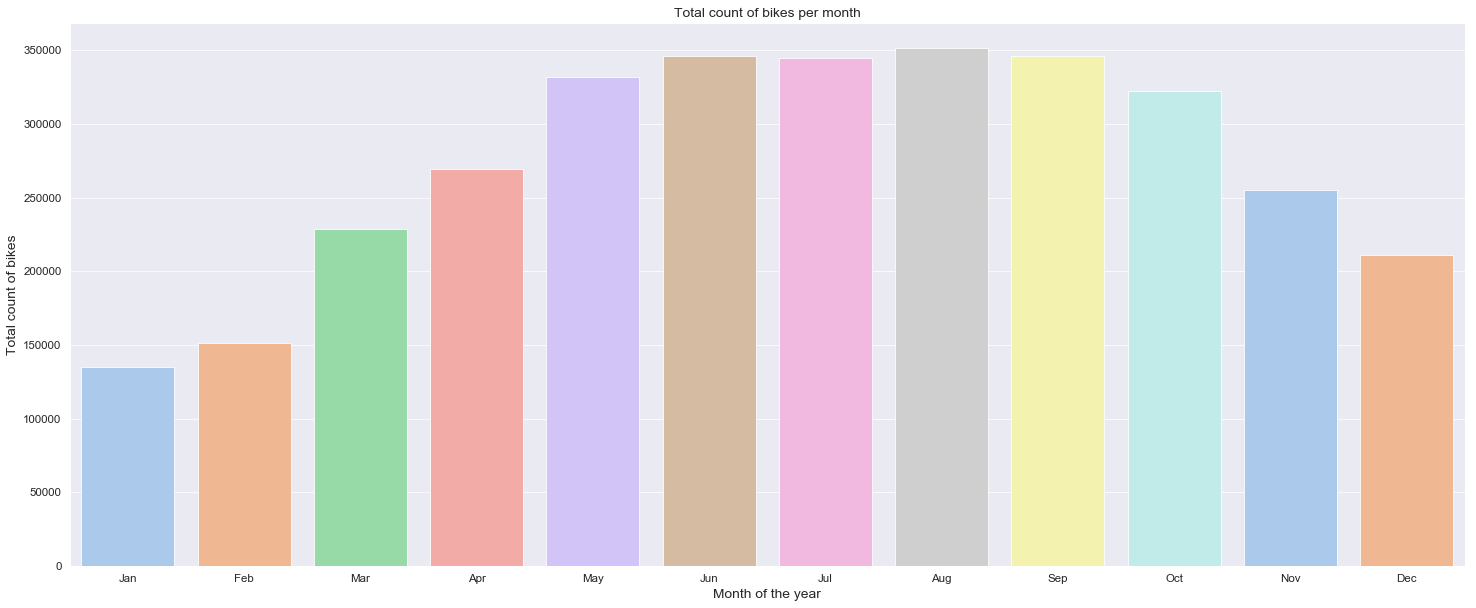

In [204]:
fig, ax = plt.subplots()
monthly_plot = sns.barplot(data = df_hour[['mnth',
                                        'cnt']].compute(),
                           x = 'mnth',
                           y = 'cnt',
                           ci = None,
                           palette='pastel',
                           estimator = sum)
ax.set(xlabel = 'Month of the year', ylabel = 'Total count of bikes', title = 'Total count of bikes per month')
ax.set_xticklabels(['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [156]:
dummy_encoder = DummyEncoder()
df_hour_encoded = dummy_encoder.fit_transform(df_hour.categorize())

df_hour_encoded.head()

,instant,dteday,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0.24,0.2879,0.81,0.0,3,13,16,1,...,0,0,0,1,1,0,1,0,0,0
1,2,2011-01-01,0.22,0.2727,0.80,0.0,8,32,40,1,...,0,0,0,1,1,0,1,0,0,0
2,3,2011-01-01,0.22,0.2727,0.80,0.0,5,27,32,1,...,0,0,0,1,1,0,1,0,0,0
3,4,2011-01-01,0.24,0.2879,0.75,0.0,3,10,13,1,...,0,0,0,1,1,0,1,0,0,0
4,5,2011-01-01,0.24,0.2879,0.75,0.0,0,1,1,1,...,0,0,0,1,1,0,1,0,0,0


In [117]:
df_hour['dteday'] = dd.to_datetime(df_hour.dteday)

In [147]:
data_hourly = df_hour.copy()
data_hourly = data_hourly.loc[data_hourly["dteday"] < "2012-10-1"].compute()
data_hourly.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Correlation Matrix

To see which non-categorical features are very correlated, we design a correlation matrix. 
This matrix will tell us which ones are too heavily correlated which impacts models in a negative way and causes overfitting. After checking for the correlation, we'll have to decide to drop some of the variables. 

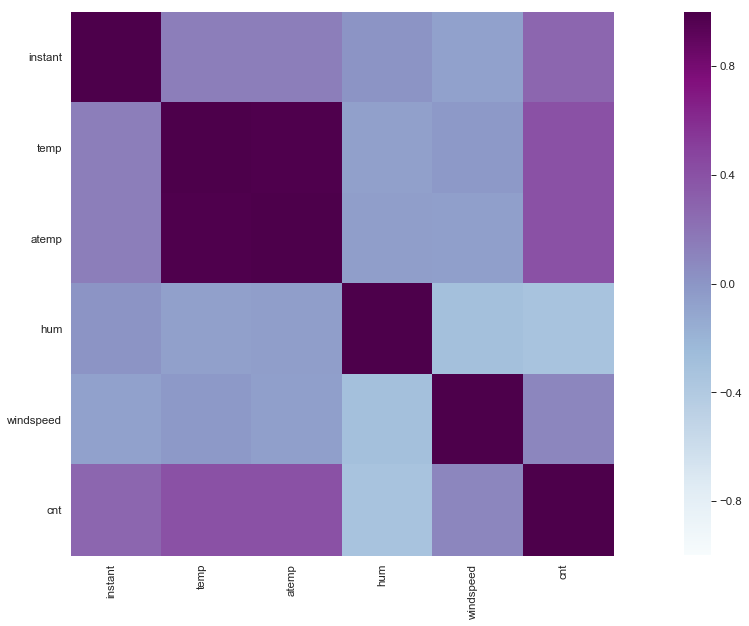

In [206]:
names = ['instant','temp','atemp','hum','windspeed','cnt']
ax = sns.heatmap(
    df_hour.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap="BuPu",
    square=True
)
ax.set_xticklabels(names,
    rotation=90,
    horizontalalignment='right'
)

ax.set_yticklabels(names,
    rotation=0
);

In [26]:
df_hour['day'] = df_hour['dteday'].dt.day
df_hour = df_hour.drop(['instant', 'dteday'], axis = 1)
df_hour.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


In [71]:
from dask_ml.preprocessing import OneHotEncoder
onehot_encode = OneHotEncoder
dataset = onehot_encode(df_hour)

In [72]:
dataset = dd.get_dummies(df_hour.categorize()).compute()


In [73]:
dataset.head()

,instant,temp,atemp,hum,windspeed,casual,registered,cnt,dteday_2011-01-01,dteday_2011-01-02,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,0.24,0.2879,0.81,0.0,3,13,16,1,0,...,0,0,0,1,1,0,1,0,0,0
1,2,0.22,0.2727,0.80,0.0,8,32,40,1,0,...,0,0,0,1,1,0,1,0,0,0
2,3,0.22,0.2727,0.80,0.0,5,27,32,1,0,...,0,0,0,1,1,0,1,0,0,0
3,4,0.24,0.2879,0.75,0.0,3,10,13,1,0,...,0,0,0,1,1,0,1,0,0,0
4,5,0.24,0.2879,0.75,0.0,0,1,1,1,0,...,0,0,0,1,1,0,1,0,0,0


In [89]:
X = df_hour.loc[:, df_hour.columns != 'cnt']
y = df_hour.loc[:, ['instant','cnt']]

In [95]:
X_train = X.loc[(X.instant <= 15211)].drop(['dteday', 'cnt', 'instant', 'registered','casual'], axis=1)
y_train = y.loc[(y.instant <= 15211)].drop('instant', axis=1)
X_test = X.loc[(X.instant > 15211)].drop(['dteday', 'instant', 'registered','casual'], axis=1)
y_test = y.loc[(y.instant > 15211)].drop('instant', axis=1)

ValueError: Metadata inference failed in `drop`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("['cnt'] not found in axis")

Traceback:
---------
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/dataframe/utils.py", line 160, in raise_on_meta_error
    yield
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/dataframe/core.py", line 3697, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/dask/utils.py", line 716, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/pandas/core/frame.py", line 3940, in drop
    errors=errors)
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/pandas/core/generic.py", line 3780, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/pandas/core/generic.py", line 3812, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/Users/camillechauliac/anaconda/envs/Python3.7/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4965, in drop
    '{} not found in axis'.format(labels[mask]))


In [91]:
X_train_arr = X_train.values
X_test_arr = X_test.values
y_train_arr = y_train.values
y_test_arr = y_test.values

In [92]:
l_model = LinearRegression()
l_model.fit(X_train_arr, y_train_arr)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [106]:
Base_data = df_hour.categorize().compute()

Base_data.head()

Base_data = Base_data.drop(['registered'], axis = 1)

In [107]:
Base_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1
